# Case 3 : Patient Drug Review

**Ismail Barkin Ulusoy <br>
Kritameth Coothongkul <br>
Jiwon Lee <br>
Nayoun Kang** <br>

**<br>Last Edited : 18th March 2020<br>**
**<font size="4">Helsinki Metropolia University of Applied Sciences<font size="4">**

**<font size="6">Background**

The objective of this document is to create a text processing and a classifier to address the following question: **"Can you predict the rating of the drug based on the review?"** from a collection of patient drug reviews extracted from https://www.drugs.com/ through convolutional (1D) neural networks.

**<font size="6">Data**

Our datasets were provided by Jessica Li at Ref: https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018/home<br>
which was originally published on the "UCI Machine Learning repository" Ref: https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29<br>
In which these datasets are the reviews of drugs written by users who have used these drugs before.

In [1]:
%pylab inline
import time # for timing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from sklearn.model_selection import train_test_split # preprocessing datasets
from tensorflow.keras.preprocessing.text import Tokenizer # text preprocessing
from tensorflow.keras.models import Sequential # modeling neural networks
from tensorflow.keras.layers import Dense, Activation, Embedding, SimpleRNN,Flatten # layers for neural networks
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Get the training and test data
dftrain = pd.read_csv('C:/Users/Marker/Downloads/kuc-hackathon-winter-2018/drugsComTrain_raw.csv')
dftest = pd.read_csv('C:/Users/Marker/Downloads/kuc-hackathon-winter-2018/drugsComTest_raw.csv')

The datasets that were given were split into 2 sets training and test, where the training sets are already known by the model where as the test sets are not.

In [3]:
dftrain.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


The datasets show the review of a drug used by a patient which is represented by a uniqueID,with each drug having a 10 star rating scale where 1 is bad and 10 is good.

We split the datasets into list, with each list only having reviews and star ratings.

In [4]:
train_samples = dftrain['review'].values.tolist()
#train_labels = dftrain['rating'].values
test_samples = dftest['review'].values.tolist()
#test_labels = dftest['rating'].values

After that we split the list into 3 different categories:<br>
 drugs that got a rating from 1 to 4 stars would be labeled 0<br>
 drugs that got a rating from 5 to 6 stars would be labeled 1<br>
 drugs that got a rating that is higher than 6 stars (7 stars and up) would be labeled 2<br>

In [5]:
# Create three categories
# label = 2, when rating = 6..
# label = 1, when rating = 5..6
# label = 0, when rating = 1..4
train_labels = dftrain['rating'].values
for i in range(len(train_labels)):
    x = train_labels[i]
    if x > 6:
        train_labels[i] = 2
    elif (x == 5 or x == 6):
        train_labels[i] = 1
    else:
        train_labels[i] = 0
        
test_labels = dftest['rating'].values
for i in range(len(test_labels)):
    x = test_labels[i]
    if x > 6:
        test_labels[i] = 2
    elif (x == 5 or x == 6):
        test_labels[i] = 1
    else:
        test_labels[i] = 0

To make the model understand what each sentence mean we need to split each sentences into words first, however since there are a lot of different words that will be used in each review we decided to build up a word index that consist of only the most common 5000 words found from all reviews.

In [6]:
%%time
# Build up the word index (only 5000 most common words)

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(train_samples)

Wall time: 9.02 s


The output will be a word index of up to 5000 words, which will cannot be fed into the model therefore we will change each word into numbers instead.

In [7]:
# Convert reviews to integer sequences

train_sequences = tokenizer.texts_to_sequences(train_samples)
test_sequences = tokenizer.texts_to_sequences(test_samples)
print(train_sequences[0])

[5, 38, 28, 35, 197, 1, 45, 5, 15, 848, 12, 2922, 99, 150, 2, 3806, 1551]


Here we make the reviews have the same length so they can be input into the model with a maximum of 100 words.

In [8]:
# Pad the reviews to have the same length

from tensorflow.keras import preprocessing

maxlen = 100

train_sequences = preprocessing.sequence.pad_sequences(train_sequences, maxlen = maxlen)
test_sequences = preprocessing.sequence.pad_sequences(test_sequences, maxlen = maxlen)
print(train_sequences[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    5
   38   28   35  197    1   45    5   15  848   12 2922   99  150    2
 3806 1551]


We also needed to change the muticlass labels into a one-hot form to not invoke the categorical loss error.

In [9]:
# Preprocess the multiclass labels to one-hot form

from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

print(train_labels[:5])

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


Finally we flatten the data so it can be fed into the input layer.

In [10]:
# Use word vectors of dimension 2, flatten and feed straight to output layer

model = Sequential()
model.add(Embedding(5000, 2, input_length = maxlen))
model.add(Flatten())
model.add(Dense(3, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 2)            10000     
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 603       
Total params: 10,603
Trainable params: 10,603
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Compile the model

model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])

Now we train the model to see if it can predict the rating of a drug from the reviews. We also splitted 20% from the training set to be used as validation.

In [12]:
%%time
# Train the model

history = model.fit(train_sequences, train_labels, epochs = 5, batch_size=32, validation_split = 0.2)

Train on 129037 samples, validate on 32260 samples
Epoch 1/5
129037/129037 [==============================] - 134s 1ms/sample - loss: 0.6645 - acc: 0.7401 - val_loss: 0.5913 - val_acc: 0.7746
Epoch 2/5
129037/129037 [==============================] - 145s 1ms/sample - loss: 0.5708 - acc: 0.7861 - val_loss: 0.5804 - val_acc: 0.7814
Epoch 3/5
129037/129037 [==============================] - 140s 1ms/sample - loss: 0.5591 - acc: 0.7917 - val_loss: 0.5779 - val_acc: 0.7826
Epoch 4/5
129037/129037 [==============================] - 155s 1ms/sample - loss: 0.5537 - acc: 0.7939 - val_loss: 0.5765 - val_acc: 0.7854
Epoch 5/5
129037/129037 [==============================] - 143s 1ms/sample - loss: 0.5496 - acc: 0.7952 - val_loss: 0.5777 - val_acc: 0.7835
Wall time: 11min 56s


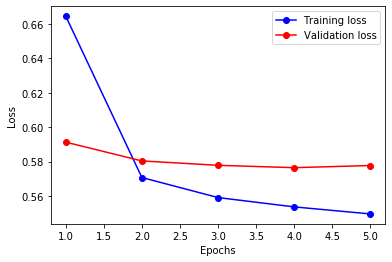

In [13]:
# Plot the training progress, first the loss function ...

import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, 'bo-', label='Training loss')
plt.plot(epochs, val_loss_values, 'ro-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

From the results we can see that the training model is doing great as the training loss goes down after each epoch, as for the validation loss it goes down the first 3 epochs then slighty rise up after that, so it is not perfect but still somewhat stable. Therefore ther is a chance that 5 epochs may be overfitting.

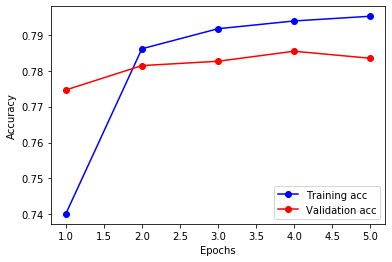

In [14]:
# ... and the accuracy.

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo-', label='Training acc')
plt.plot(epochs, val_acc_values, 'ro-', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

As for the accuracy we can see that the model is also doing great as the training accuracy goes up after each epoch, however the validation accuracy slighty increase at the 2nd epoch and was then stable until the 5th epoch where it slighty went down, so it is not perfect but still stable enough to be usable.

Now we test our model by using the test sets to see how accurate is the model when getting new data.

In [15]:
# Evaluate with test data

model.evaluate(test_sequences, test_labels)

53766/53766 [==============================] - 55s 1ms/sample - loss: 0.5751 - acc: 0.7870


[0.5750904359535656, 0.7869657]

In [16]:
prediction = model.predict(test_sequences)

In [17]:
# This has been done since Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets
test_labels_singular = np.argmax(test_labels, axis=1)
prediction_singular = np.argmax(prediction, axis=1)

In [18]:
confusion_m =confusion_matrix(test_labels_singular,prediction_singular)
print(confusion_m)

[[ 9282    32  4183]
 [ 1652    45  3132]
 [ 2418    37 32985]]


In [19]:
classification_r = classification_report(test_labels_singular,prediction_singular)
print(classification_r)

              precision    recall  f1-score   support

           0       0.70      0.69      0.69     13497
           1       0.39      0.01      0.02      4829
           2       0.82      0.93      0.87     35440

    accuracy                           0.79     53766
   macro avg       0.64      0.54      0.53     53766
weighted avg       0.75      0.79      0.75     53766



From the results we can see that for ratings of category 0 (1-4 stars) it has a precision of 73% therefore quite average, the model can mostly predict ratings of category 2 (7 stars and up) with up to 81% accuracy which is good. However for the category 1 (5-6 stars) the model did horribly as it can only predict 30% of it correctly. There is a high chance that this is because most reviews are likely to either be very high or very low and barely in between 5 and 6 stars therefore there might have been too little datasets for it compared to the other two categories. 

In [20]:
#Cohen kappa score of the test
cohen_k_s = cohen_kappa_score(test_labels_singular,prediction_singular)
print(cohen_k_s)

0.519549553450209


The definition of Cohen's Kappa score can be found here ref: https://en.wikipedia.org/wiki/Cohen%27s_kappa<br>
But to put it simply the closer it is to 1 it means that there is more agreement between users of a category and the the closer it is to 0 there is more disagreement between the users of a category. In other words it means the reliability of a category.<br>
<br>
This models Cohen Kappa score is at 0.5 so it is very between.

Now we will try the model by using Recurrent neural network (RNN) method instead.

In [21]:
# Try another model, this time with RNN structure

model = Sequential()
model.add(Embedding(5000, 16))
model.add(SimpleRNN(16))
model.add(Dense(3, activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          80000     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 80,579
Trainable params: 80,579
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])

In [23]:
%%time
history = model.fit(train_sequences, train_labels, epochs = 5, batch_size=32, validation_split=0.2)

Train on 129037 samples, validate on 32260 samples
Epoch 1/5
129037/129037 [==============================] - 286s 2ms/sample - loss: 0.6317 - acc: 0.7621 - val_loss: 0.6427 - val_acc: 0.7487
Epoch 2/5
129037/129037 [==============================] - 287s 2ms/sample - loss: 0.5734 - acc: 0.7866 - val_loss: 0.5820 - val_acc: 0.7833
Epoch 3/5
129037/129037 [==============================] - 287s 2ms/sample - loss: 0.5600 - acc: 0.7920 - val_loss: 0.5823 - val_acc: 0.7850
Epoch 4/5
129037/129037 [==============================] - 293s 2ms/sample - loss: 0.5508 - acc: 0.7949 - val_loss: 0.5703 - val_acc: 0.7843
Epoch 5/5
129037/129037 [==============================] - 300s 2ms/sample - loss: 0.5446 - acc: 0.7967 - val_loss: 0.5714 - val_acc: 0.7882
Wall time: 24min 14s


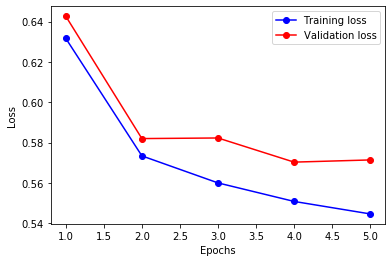

In [24]:
# Plot the training progress, first the loss function ...

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, 'bo-', label='Training loss')
plt.plot(epochs, val_loss_values, 'ro-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

From the results we can see that the training loss is almost the same as the previous model. However the validation loss is worse than the previous model as it fluctuates more and by epoch 5 the loss is higher than it was at the beginning.

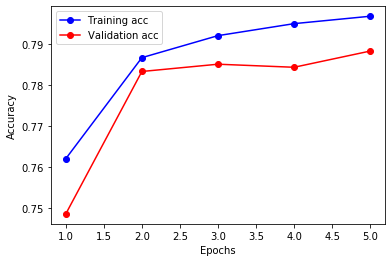

In [25]:
# ... and the accuracy.

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo-', label='Training acc')
plt.plot(epochs, val_acc_values, 'ro-', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The training accuracy also seems the same as the previous model, as for the validation accuracy it is worse once again as it fluctuates more and is lower at epoch 5 to its 1st epoch.

In [26]:
model.evaluate(test_sequences, test_labels)

53766/53766 [==============================] - 107s 2ms/sample - loss: 0.5666 - acc: 0.7915


[0.5665647675162451, 0.7915225]

In [27]:
prediction = model.predict(test_sequences)

In [28]:
# This has been done since Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets
test_labels_singular = np.argmax(test_labels, axis=1)
prediction_singular = np.argmax(prediction, axis=1)

In [29]:
confusion_m =confusion_matrix(test_labels_singular,prediction_singular)
print(confusion_m)

[[ 9845    12  3640]
 [ 1880    23  2926]
 [ 2707    44 32689]]


In [30]:
classification_r = classification_report(test_labels_singular,prediction_singular)
print(classification_r)

              precision    recall  f1-score   support

           0       0.68      0.73      0.71     13497
           1       0.29      0.00      0.01      4829
           2       0.83      0.92      0.88     35440

    accuracy                           0.79     53766
   macro avg       0.60      0.55      0.53     53766
weighted avg       0.75      0.79      0.75     53766



From the result, the RNN model can predict category 2 better than the previous model at  86% compared to the previous model at 81%, but the accuracy for category 0 and 1 are lower.

In [31]:
#Cohen kappa score of the test
cohen_k_s = cohen_kappa_score(test_labels_singular,prediction_singular)
print(cohen_k_s)

0.537982216386978


As for the Cohen's Kappa score, the RNN model got around 0.53 therefore not really that different from the previous model.

When we compare both models to 'Grässer et al. Table 2, p. 12' we can see the cohen score is more in the middle rather than like the Article where its Closer to disagreement. Accuracy wise our RNN model did better compared in some categories listed above